In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Load the dataset with a different encoding
file_path = "TrafficLabelling\\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
try:
    # Try latin-1 encoding first
    df = pd.read_csv(file_path, encoding='latin-1')
    print("File loaded successfully with latin-1 encoding!")
except UnicodeDecodeError:
    try:
        # If latin-1 fails, try windows-1252
        df = pd.read_csv(file_path, encoding='windows-1252')
        print("File loaded successfully with windows-1252 encoding!")
    except UnicodeDecodeError:
        # If that fails, try iso-8859-1
        df = pd.read_csv(file_path, encoding='iso-8859-1')
        print("File loaded successfully with iso-8859-1 encoding!")
    except Exception as e:
        print(f"Failed to load file: {e}")
        exit()
df.columns = df.columns.str.strip()

# Drop rows where all columns are NaN
print(f"\nInitial number of rows: {len(df)}")
df = df.dropna(how='all')
print(f"Number of rows after dropping empty rows: {len(df)}")

df


C:\Users\soka1\AppData\Local\Temp\ipykernel_113724\1485257022.py:5: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin-1')


File loaded successfully with latin-1 encoding!

Initial number of rows: 458968
Number of rows after dropping empty rows: 170366


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.50-389-33898-6,192.168.10.50,33898.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113095465.0,48.0,24.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,BENIGN
1,192.168.10.3-192.168.10.50-389-33904-6,192.168.10.50,33904.0,192.168.10.3,389.0,6.0,6/7/2017 8:59,113473706.0,68.0,40.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,BENIGN
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 8:59,119945515.0,150.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,BENIGN
3,192.168.10.14-65.55.44.109-59135-443-6,192.168.10.14,59135.0,65.55.44.109,443.0,6.0,6/7/2017 8:59,60261928.0,9.0,7.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.14-53-59555-17,192.168.10.14,59555.0,192.168.10.3,53.0,17.0,6/7/2017 8:59,269.0,2.0,2.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170361,157.240.18.35-192.168.10.51-443-55641-6,157.240.18.35,443.0,192.168.10.51,55641.0,6.0,6/7/2017 12:59,49.0,1.0,3.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170362,192.168.10.51-199.16.156.120-45337-443-6,199.16.156.120,443.0,192.168.10.51,45337.0,6.0,6/7/2017 12:59,217.0,2.0,1.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170363,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148.0,192.168.10.50,22.0,6.0,6/7/2017 12:59,1387547.0,41.0,46.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN
170364,192.168.10.12-192.168.10.50-60146-22-6,192.168.10.12,60146.0,192.168.10.50,22.0,6.0,6/7/2017 12:59,207.0,1.0,1.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,BENIGN


In [34]:
# Function to convert IP address to a single integer
def ip_to_int(ip):
    try:
        # Split the IP address into octets
        octets = ip.split('.')
        # Convert to integer: (octet1 * 256^3) + (octet2 * 256^2) + (octet3 * 256) + octet4
        return int(octets[0]) * 256**3 + int(octets[1]) * 256**2 + int(octets[2]) * 256 + int(octets[3])
    except:
        return 0  # Handle invalid IPs by returning 0 (or you can choose to drop these rows)
df = df.drop('Flow ID', axis=1)
df['Label'] = df['Label'].apply(lambda x: 1 if isinstance(x, str) and 'Web Attack' in x else 0)

# Convert IP columns to integers
for col in ['Source IP', 'Destination IP']:
    df[col] = df[col].apply(ip_to_int)

In [35]:
df.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3232238130,33898.0,3232238083,389.0,6.0,6/7/2017 8:59,113095465.0,48.0,24.0,9668.0,...,32.0,203985.500,5.758373e+05,1629110.0,379.0,13800000.0,4.277541e+06,16500000.0,6737603.0,0
1,3232238130,33904.0,3232238083,389.0,6.0,6/7/2017 8:59,113473706.0,68.0,40.0,11364.0,...,32.0,178326.875,5.034269e+05,1424245.0,325.0,13800000.0,4.229413e+06,16500000.0,6945512.0,0
2,134610945,0.0,134219268,0.0,0.0,6/7/2017 8:59,119945515.0,150.0,0.0,0.0,...,0.0,6909777.333,1.170000e+07,20400000.0,6.0,24400000.0,2.430000e+07,60100000.0,5702188.0,0
3,3232238094,59135.0,1094134893,443.0,6.0,6/7/2017 8:59,60261928.0,9.0,7.0,2330.0,...,20.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0
4,3232238094,59555.0,3232238083,53.0,17.0,6/7/2017 8:59,269.0,2.0,2.0,102.0,...,32.0,0.000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0


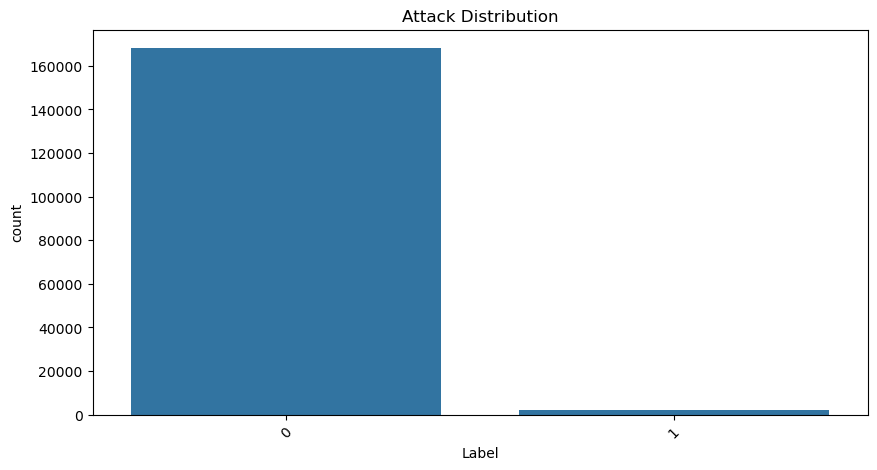

In [36]:
# Visualization - Attack Distribution
if 'Label' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='Label')
    plt.xticks(rotation=45)
    plt.title("Attack Distribution")
    plt.show()


In [39]:
# Handle Timestamp
# Convert to datetime, coercing invalid entries to NaT
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Check for invalid timestamps (NaT)
invalid_timestamps = df['Timestamp'].isna().sum()
if invalid_timestamps > 0:
    print(f"Warning: {invalid_timestamps} invalid timestamps (NaT) found. These will be handled by filling with a default value.")
    # Fill NaT with the earliest valid timestamp to maintain chronological order
    valid_timestamps = df['Timestamp'].dropna()
    default_timestamp = valid_timestamps.min() if not valid_timestamps.empty else pd.Timestamp('1970-01-01')
    df['Timestamp'] = df['Timestamp'].fillna(default_timestamp)

# Convert to Unix timestamp (seconds since epoch)
df['Timestamp'] = df['Timestamp'].astype('int64') // 10**9  # Convert nanoseconds to seconds

# Sort by Timestamp
df = df.sort_values('Timestamp')

# Verify the range of timestamps
print(f"\nTimestamp range: {pd.to_datetime(df['Timestamp'], unit='s').min()} to {pd.to_datetime(df['Timestamp'], unit='s').max()}")


Timestamp range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00



Checking for infinite values in X before handling:

Checking for infinite values in X after handling:

Checking for extremely large values in X:

Training set distribution:
Label
0    0.987204
1    0.012796
Name: proportion, dtype: float64

Test set distribution:
Label
0    0.987204
1    0.012796
Name: proportion, dtype: float64


c:\Users\soka1\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     33638
      Attack       1.00      1.00      1.00       436

    accuracy                           1.00     34074
   macro avg       1.00      1.00      1.00     34074
weighted avg       1.00      1.00      1.00     34074



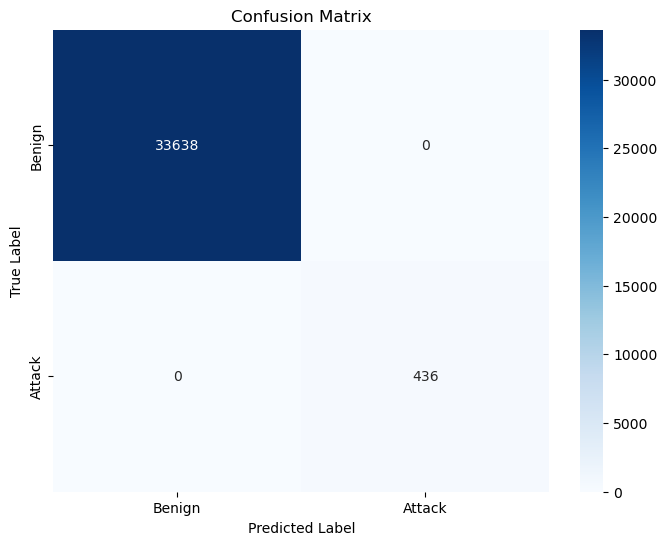

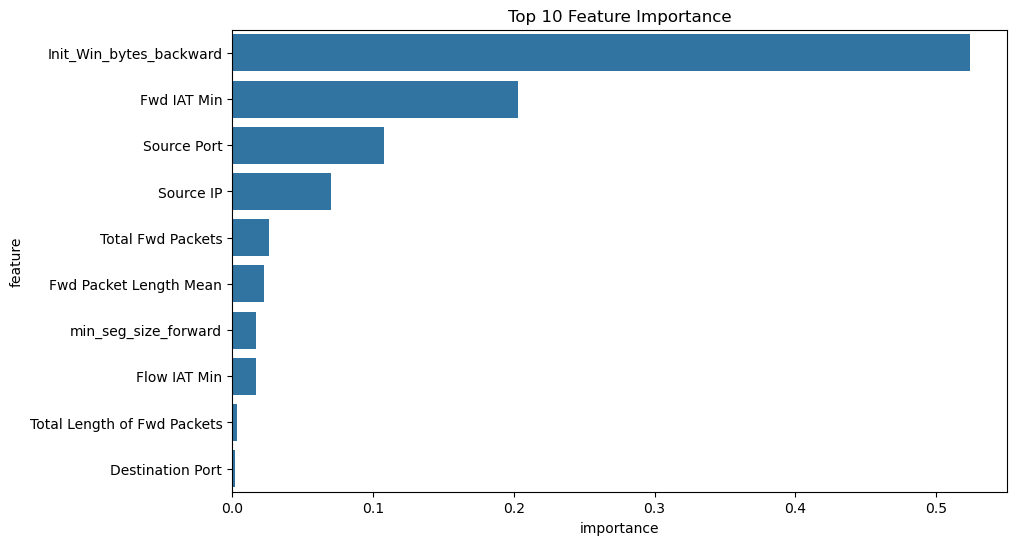

In [45]:
# Check for infinite values before handling
print("\nChecking for infinite values in X before handling:")
inf_columns = X.columns[X.isin([np.inf, -np.inf]).any()]
for col in inf_columns:
    print(f"Column '{col}' contains {X[col].isin([np.inf, -np.inf]).sum()} infinite values")

# Replace infinite values with NaN and fill with mean
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Check for infinite values after handling
print("\nChecking for infinite values in X after handling:")
inf_columns = X.columns[X.isin([np.inf, -np.inf]).any()]
for col in inf_columns:
    print(f"Column '{col}' contains {X[col].isin([np.inf, -np.inf]).sum()} infinite values")

# Check for extremely large values
print("\nChecking for extremely large values in X:")
large_value_threshold = 1e308  # Max value for float64
large_columns = X.columns[(X.abs() > large_value_threshold).any()]
for col in large_columns:
    print(f"Column '{col}' contains values larger than {large_value_threshold}")

# Clip values to prevent overflow
X = X.clip(lower=-1e308, upper=1e308)

# Stratified 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify class distribution in train and test sets
print("\nTraining set distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

# Initialize and train XGBoost model (no scaling)
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Print results
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Attack']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance
feature_importance = xgb_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', 
            data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.show()